In [308]:
%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
import tifffile
import napari
from matplotlib import pyplot as plt
from skvideo import io as skvideo_io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [309]:
import sys
sys.path.append("../src")
from classif_utils import *
from convpaint_utils import *
from dino_utils import *
from ilastik_utils import *
from rf_utils import *
from util_funcs import *

In [310]:
mouse_vid = skvideo_io.vread("../data/deeplabcut_mouse_demo_m3v1mp4.mp4")
mouse_vid.shape

(2330, 480, 640, 3)

In [358]:
img = mouse_vid[0]
# img = img[:,:,0]
img.shape

(480, 640, 3)

In [359]:
v = napari.view_image(img)

In [313]:
# labels = v.layers['Labels'].data
# tifffile.imsave("../data/mouse_vid_labels_frame0.tif", labels.astype(np.uint8))

labels = tifffile.imread("../data/mouse_vid_labels_frame0.tif")
v.add_labels(labels)
print(labels.shape)
print(np.sum(labels > 0))

(480, 640)
1604


## Convpaint

In [314]:
annot_features, targets, model = get_convpaint_features_targets_model(img, labels, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(annot_features.shape)
print(targets.shape)

(1604, 384)
(1604,)


In [315]:
feature_space = get_convpaint_feature_space(img, layer_list=[0], scalings=[1,2], model_name="vgg16")
feature_space.shape

(480, 640, 384)

In [316]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Convpaint")

<Image layer 'Feature Space Convpaint' at 0x1bde451f190>

In [317]:
kmeans = get_kmeans_clusters(feature_space, num_clusters=3, img_shape=None)
kmeans.shape

(480, 640)

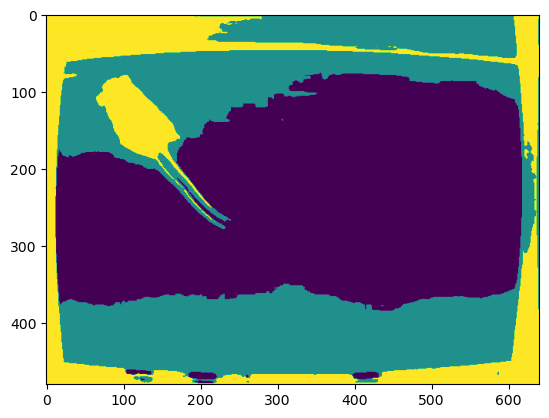

In [318]:
plt.imshow(kmeans)

In [319]:
pc = get_pca_features(feature_space, num_components=2)
print(pc.shape)

(480, 640, 2)


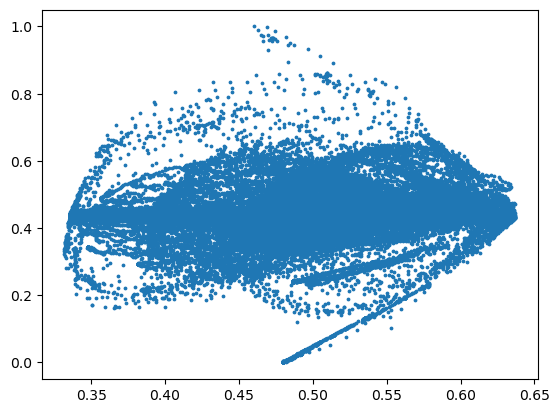

In [320]:
pc_1d = pc.reshape(-1, 2)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [321]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=3, img_shape=None)
kmeans_p.shape

(480, 640)

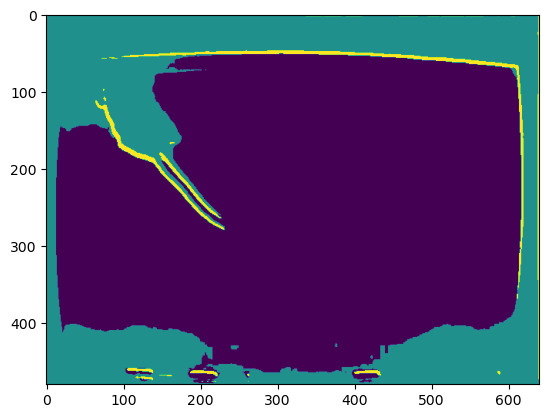

In [322]:
plt.imshow(kmeans_p)

In [323]:
pc_annot = get_pca_features(annot_features, num_components=2)
print(pc_annot.shape)

(1604, 2)


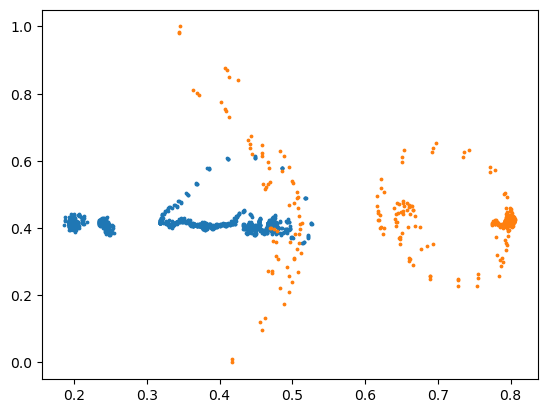

In [324]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## DINOv2

In [325]:
patch_features = get_dinov2_patch_features(img)
patch_features.shape

(1610, 384)

In [326]:
feature_space = get_dinov2_feature_space(img, interpolate_features=False)
feature_space.shape

(480, 640, 384)

In [327]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space DINOv2")

<Image layer 'Feature Space DINOv2' at 0x1bde6f7eaf0>

In [328]:
pix_features = get_dinov2_pixel_features(img, interpolate_features=False)
pix_features.shape

(307200, 384)

In [329]:
annot_features, targets = get_dinov2_features_targets(img, labels, interpolate_features=False)
print(annot_features.shape)
print(targets.shape)

(1604, 384)
(1604,)


In [330]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=3, img_shape=None)
kmeans_f.shape

(480, 640)

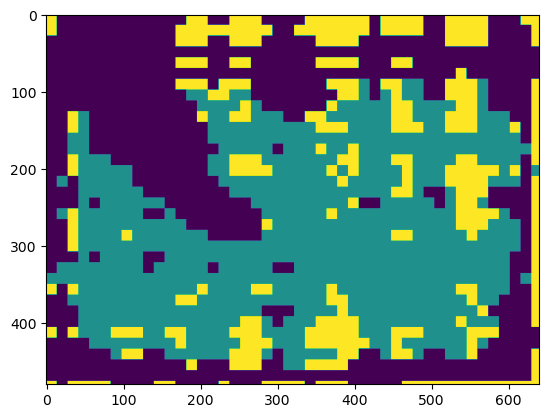

In [331]:
plt.imshow(kmeans_f)

In [332]:
pc = get_pca_features(feature_space, num_components=2)
print(pc.shape)

(480, 640, 2)


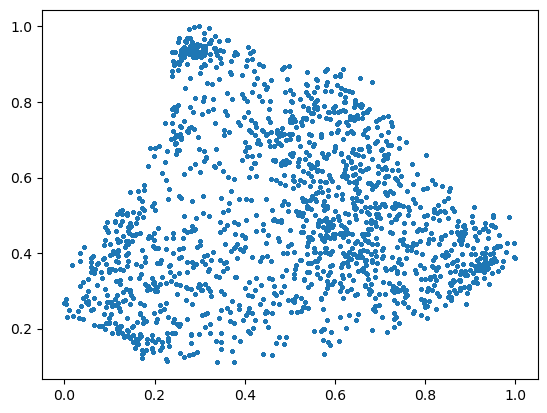

In [333]:
pc_1d = pc.reshape(-1, 2)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [334]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=3)
kmeans_p.shape

(480, 640)

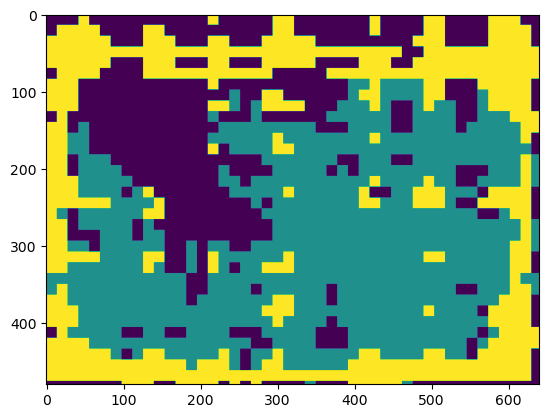

In [335]:
plt.imshow(kmeans_p)

In [336]:
pc_annot = get_pca_features(annot_features, num_components=2)
print(pc_annot.shape)

(1604, 2)


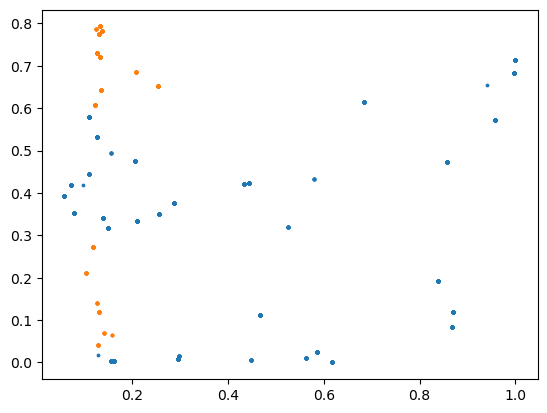

In [337]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Ilastik

In [370]:
feature_space = get_ila_feature_space(img)
feature_space.shape

(480, 640, 168)

In [361]:
annot_features, targets = get_ila_features_targets(img, labels)

In [362]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Ilastik")

<Image layer 'Feature Space Ilastik' at 0x1bddf40df40>

In [371]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=3)
kmeans_f.shape

(480, 640)

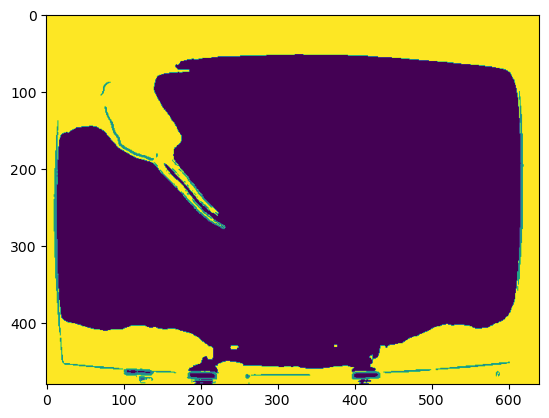

In [342]:
plt.imshow(kmeans_f)

In [372]:
pc = get_pca_features(feature_space, num_components=2)
print(pc.shape)

(480, 640, 2)


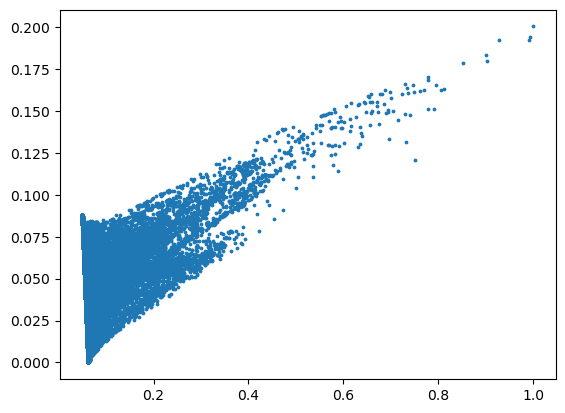

In [344]:
pc_1d = pc.reshape(-1, 2)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [373]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=3)
kmeans_p.shape

(480, 640)

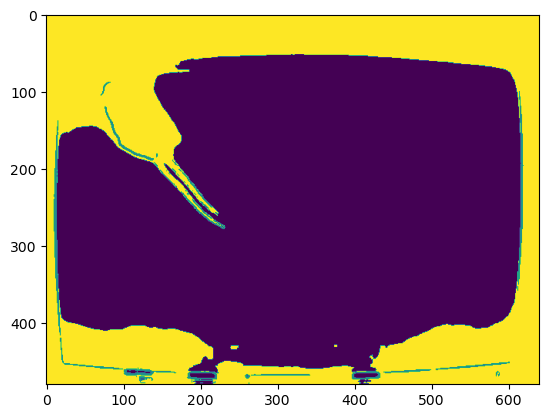

In [346]:
plt.imshow(kmeans_p)

In [347]:
pc_annot = get_pca_features(annot_features, num_components=2)
print(pc_annot.shape)

(1604, 2)


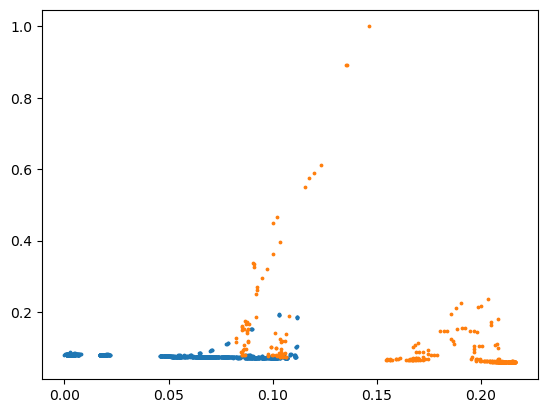

In [348]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Test random forest functions

In [349]:
# features_func_train = get_convpaint_features_targets_model
# features_func_pred = get_convpaint_feature_space
# features_cfg = {"layer_list": [0], "scalings": [1,2], "model_name": "vgg16"}
features_func_train = get_dinov2_features_targets
features_func_pred = get_dinov2_feature_space
# features_func_pred = get_dinov2_pixel_features
# features_func_pred = get_dinov2_patch_features
features_cfg = {"pc": 0}
# features_func_train = get_ila_features_targets
# features_func_pred = get_ila_feature_space
# features_cfg = {}

In [350]:

rf = train_seg_forest([img], [labels], features_func_train, features_cfg, print_steps=True, random_state=0)

Extracting features for labels 1/1 - estimated time left: NA


In [351]:
pred = predict_seg_forest_single_image(img, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14))
print(pred.shape)

(480, 640)


In [352]:
v.add_labels(pred, name="Pred Labels")

<Labels layer 'Pred Labels' at 0x1bde181f8b0>

In [353]:
pred_vid = mouse_vid.copy()
pred_vid = pred_vid[:50:4]

In [354]:
v2 = napari.view_image(pred_vid)

In [356]:
pred_batch = predict_seg_forest(pred_vid, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14), print_steps=True)

Predicting image 1/13 - estimated time left: NA
Predicting image 2/13 - estimated time left: 116.2 seconds
Predicting image 3/13 - estimated time left: 87.6 seconds
Predicting image 4/13 - estimated time left: 73.0 seconds
Predicting image 5/13 - estimated time left: 62.0 seconds
Predicting image 6/13 - estimated time left: 53.2 seconds
Predicting image 7/13 - estimated time left: 45.1 seconds
Predicting image 8/13 - estimated time left: 38.0 seconds
Predicting image 9/13 - estimated time left: 31.4 seconds
Predicting image 10/13 - estimated time left: 25.4 seconds
Predicting image 11/13 - estimated time left: 18.9 seconds
Predicting image 12/13 - estimated time left: 12.7 seconds
Predicting image 13/13 - estimated time left: 6.3 seconds


In [357]:
v2.add_labels(pred_batch)

<Labels layer 'pred_batch' at 0x1bde70d7580>